# Deep generative model using keras on MNIST dataset.
#### By Rohan Junaid Khan. 

There are multiple deep generative model and Variational Auto-encoder (VAE) is one of the popular one. There are three parts of a VAE structure: Encoder, latent space and decoder. The encoder takes input image (in this case), flattens its features into 1D space which we can call the vector representation of the input and then these latent variables are converted into a gaussian distribution to feed the latent space. Basically, the parameter that the latent space gets is the mean and the log of variance of the whole input variables. Decoder part generates new images from the information given by the latent space. The latent space creates random sample vector from the gaussian distribution to feed the decoder model.

A variation of VAE called **Conditional Variational Auto-encoder (CVAE)** has been implemented here. The advantage of CVAE over VAE is that it can generate a specific image which is demanded from the decoder model where VAE generates the whole latent space output. We give the labels of input images as form of one hot encode to the encoder and decoder input so it can identify the generated image as the label suggests. For example, we give images of numbers from 0 to 9 from the MNIST dataset to encoder also, we feed the label value of those specific input images to encoder and decoder input so the generation is conditioned by the labels.  

### Required packages and libraries

I have chosen tensorflow keras's library set to implement this model. There are also use of numpy and matplotlib libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.manifold import TSNE
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda, concatenate, Dropout, BatchNormalization
from keras.models import Model
from keras import backend as K
from keras import losses
from keras.utils import to_categorical
from scipy.stats import norm
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

### Data normalization and reshaping

Here we first load the data and normalized them to the range of [0,1]. This solves the issue that might have arisen from different scale of the images. After that, Each 28x28 image is flattened into a single vector of 784 elements (28 * 28). This vectorization is required because neural networks expect input as a one-dimensional array. Then, The labels are transformed using one-hot encoding, converting numerical class labels into binary vectors (e.g., class 9 becomes [0, 0, 0, 0, 0, 0, 0, 0, 0, 1] for the 10-class MNIST dataset). This format helps the neural network better distinguish classes.
We also defined the network parameters like batch size, number of epochs, size of the hidden layer of encoder and decoder and the number of dimension of latent space.

In [18]:
# data load
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# data normalization
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
#data reshaping
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
print("Input image shapes: ", x_train.shape, x_test.shape)

# one-hot encoding of the labels
y_train = to_categorical(y_train) 
y_test = to_categorical(y_test)
print("Labels Input: ", y_train.shape, y_test.shape)

# network parameters
batch_size = 20 #batch size of input for training 
n_epoch = 200 #total number of epochs
n_hidden = 512 #size of the hidden layer of encoder and decoder
z_dim = 2 #number of dimension of latent space(z)

Input image shapes:  (60000, 784) (10000, 784)
Labels Input:  (60000, 10) (10000, 10)


- Here we observe the 5 instance of digit 7 in the MNIST dataset. 

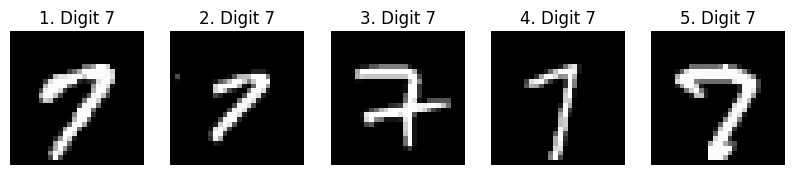

In [19]:
digit = 7
count = 5

"""Find the indices of the first 'count' occurrences of 'digit'."""
target_label = [1 if i == digit else 0 for i in range(10)]  # Create a target one-hot encoded label
indices = [id for id, label in enumerate(y_train) if all(label == target_label)][:count]

if indices:
    plt.figure(figsize=(10, 2))  
    for id, image_index in enumerate(indices):
        plt.subplot(1, 5, id + 1)
        plt.imshow(x_train[image_index].reshape(28, 28), cmap='gray')
        plt.title(f"{id + 1}. Digit {digit}")
        plt.axis("off")
    plt.show()
else:
    print(f"Digit {digit} not found in the dataset.")

### Defining the Encoder using NN and latent space representation

We used simple neural network to implement the encoder layer. The image data and label information is combined into a single input tensor which allows the encoder network to condition the latent space based on the label information. We used 2 dense layer. The second one has half of the hidden layer of the first one. A dropout and normalization layer is used between these dense layers to stabilize training and prevent overfitting. Then, the latent space is sampled and represented as gaussian distribution in the form of mean(mu) and log-variance(l_sigma) encoding the high dimensional input into a lower dimensional latent space.

In [20]:
# encoder
x = Input(shape=(x_train.shape[1:]))
condition = Input(shape=(y_train.shape[1],))

inputs = concatenate([x, condition])
x_encoder = Dense(n_hidden, activation="relu")(inputs) #1st dense layer
x_encoder = Dropout(0.1)(x_encoder)  # Added Dropout
x_encoder = BatchNormalization()(x_encoder)  # Added Batch Normalization
x_encoder = Dense(n_hidden // 2, activation="relu")(x_encoder) #2nd dense layer
mu = Dense(z_dim, activation="linear")(x_encoder)
l_sigma = Dense(z_dim, activation="linear")(x_encoder)

### Sampling and Reparameterization trick

Based on the encoder output (mean and log-variance), the sampling function takes those as arguments and generates a sample from the gaussian distribution. The **eps** draws random samples from standard normal distribution and its shape matches the batch size and latent space dimension. Then, to allow backpropagation through the stochastic sampling, a reparameterization trick is employed. The trick is to compute sample latent vector by calculating the standard deviation from the log-variance multiplying with drawn random sample and adding it with the mean. The expression ensures that sampling remains differentiable, allowing the gradients to flow through the entire network. Finally, we wrap it with the **Lambda** layer which uses the Gaussian distribution parameters (mean and log-variance) to sample latent vectors and concatenate the condition variable input to feed the decoder which will generate images conditioned on this combined latent space and label.

In [21]:
# sampling function
def sampling(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0.0, stddev=1.0)
    return mu + K.exp(l_sigma / 2.0) * eps


z = Lambda(sampling, output_shape=(z_dim,))([mu, l_sigma])
decoder_input = concatenate([z, condition])

### Defining the Decoder layer using NN

Like the encoder, decoder is implemented using neural network with the opposite layer size of encoder layer. A sigmoid activation is used in the output layer to constrain pixel values to the range [0, 1]. The decoder essentially reverses the encoding process, transforming the low-dimensional latent space representation back into an interpretable image conditioned on the given label.

In [22]:
# decoder
decoder_1 = Dense(n_hidden // 2, activation="relu")
decoder_2 = Dense(n_hidden, activation="relu")
decoder_output = Dense(x_train.shape[1], activation="sigmoid")

z_encoder = decoder_1(decoder_input)
z_encoder = decoder_2(z_encoder)


y = decoder_output(z_encoder)

### Declaring the loss function and fitting the model

- **Reconstruction loss**: Calculates how well the reconstructed image matches the original image, treating each pixel as a binary classification. The loss is scaled by the number of pixels to ensure it accounts for each pixel equally in the flattened image.
- **KL Divergence**: This term measures how much the learned distribution diverges from a standard normal distribution. The goal is to ensure that the latent space is smooth and can generate new samples effectively.
- **Total loss**: This ensures that the model learns to accurately reconstruct images while maintaining a meaningful latent space representation.

#### Model fitting
A Keras Model is constructed that takes image and label inputs and outputs (the reconstructed image). Then, the loss variable is added to the model. Keras manages the backpropagation of both losses during training. The Adam optimizer is used for training with a low learning rate (0.0001) to ensure stable and gradual convergence.

In [23]:
#loss
recon_loss = losses.binary_crossentropy(x, y) * x_train.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(l_sigma) - l_sigma - 1, axis=-1)
cvae_loss = recon_loss + kl_loss

# model fitting
cvae = Model([x, condition], y)
cvae.add_loss(cvae_loss)
cvae.compile(optimizer=Adam(learning_rate=0.0001))  # Adjusted learning rate
cvae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 concatenate_5 (Concatenate  (None, 794)                  0         ['input_5[0][0]',             
 )                                                                   'input_6[0][0]']             
                                                                                                  
 dense_14 (Dense)            (None, 512)                  407040    ['concatenate_5[0][0]'] 

### Training the model

Now we train the data with input images. The validation data is also given. This callback stops training when validation loss stops improving (monitored via "val_loss"). The patience parameter controls how many epochs without improvement will trigger the stop.  

In [24]:
# training the model 
cvae.fit(
    [x_train, y_train],
    batch_size=batch_size,
    epochs=n_epoch,
    validation_data=([x_test, y_test], None),
    verbose=1,
    shuffle=True,
    callbacks=[EarlyStopping(monitor="val_loss", patience=10)],
)

Epoch 1/200
3000/3000 [==============================] - 56s 18ms/step - loss: 184.3678 - val_loss: 155.2144
Epoch 2/200
3000/3000 [==============================] - 62s 21ms/step - loss: 151.8145 - val_loss: 146.6275
Epoch 3/200
3000/3000 [==============================] - 50s 17ms/step - loss: 145.6592 - val_loss: 142.8974
Epoch 4/200
3000/3000 [==============================] - 58s 19ms/step - loss: 142.4810 - val_loss: 140.2722
Epoch 5/200
3000/3000 [==============================] - 53s 18ms/step - loss: 140.3544 - val_loss: 138.6328
Epoch 6/200
3000/3000 [==============================] - 49s 16ms/step - loss: 138.8938 - val_loss: 137.7927
Epoch 7/200
3000/3000 [==============================] - 49s 16ms/step - loss: 137.7507 - val_loss: 136.7339
Epoch 8/200
3000/3000 [==============================] - 54s 18ms/step - loss: 136.8177 - val_loss: 136.3916
Epoch 9/200
3000/3000 [==============================] - 53s 18ms/step - loss: 136.0645 - val_loss: 135.3684
Epoch 10/200
3000/3

### Building the Encoder model

The purpose of the encoder model is to take an image and its label as inputs. Produce a compact, interpretable representation of the data in the form of a mean vector mu.
The standalone encoder model will allow to visualize and analyze the latent space representation for different inputs. This is useful for understanding how the encoder processes images and conditions, and how effectively it separates different classes in the latent space.

In [25]:
# build encoder
encoder = Model([x, condition], mu)
encoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 concatenate_5 (Concatenate  (None, 794)                  0         ['input_5[0][0]',             
 )                                                                   'input_6[0][0]']             
                                                                                                  
 dense_14 (Dense)            (None, 512)                  407040    ['concatenate_5[0][0]'] 

### Scatterplot representation of latent space

Here we plot a scatterplot for the sampled distribution of the latent space.

500/500 [==============================] - 4s 3ms/step


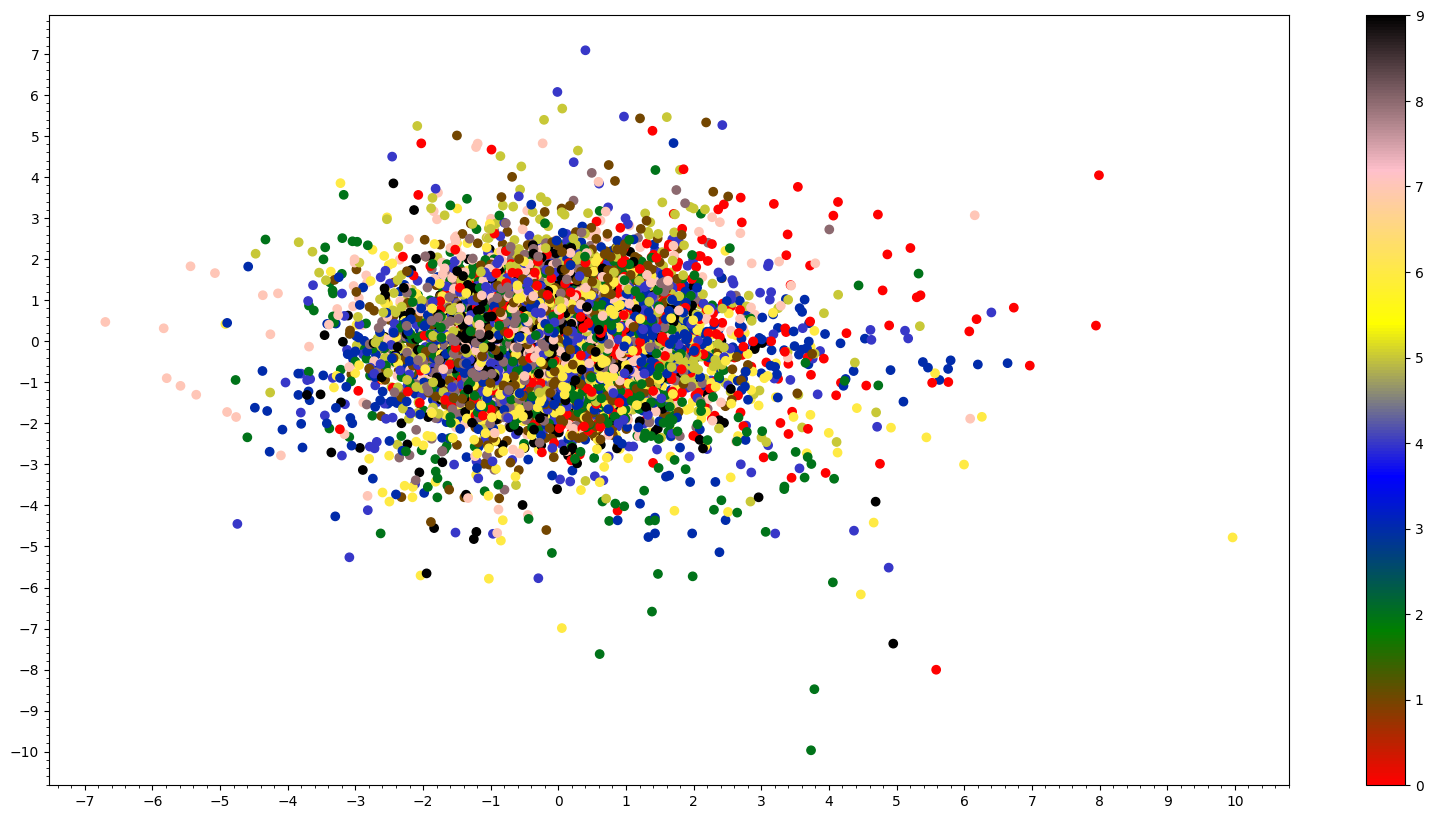

In [26]:
# Plot of the digit classes in the latent space


latent_space_map = encoder.predict([x_test, y_test], batch_size=batch_size)
plt.figure(figsize=(20, 10))
# Define a custom colormap
colors = ["red", "green", "blue", "yellow", "pink","black"]  # Define your colors here
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)


scatter = plt.scatter(
    latent_space_map[:, 0],
    latent_space_map[:, 1],
    c=np.argmax(y_test, axis=1),
    cmap=custom_cmap,
)

# Set up more detailed ticks on both axes
ax = plt.gca()  # Get current axes

# Set major tick locator and label format
ax.xaxis.set_major_locator(MultipleLocator(1))  
ax.yaxis.set_major_locator(MultipleLocator(1)) 

ax.xaxis.set_minor_locator(AutoMinorLocator(5)) 
ax.yaxis.set_minor_locator(AutoMinorLocator(5))

plt.colorbar(scatter)
plt.show()

### Building the Decoder model

As the decoder will generate new images, we defined the output as generator.

In [27]:
# build decoder
decoder_input = Input(shape=(z_dim + y_train.shape[1],))
cz_decoder = decoder_1(decoder_input)
cz_decoder = decoder_2(cz_decoder)
_y = decoder_output(cz_decoder)
generator = Model(decoder_input, _y)
generator.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense_18 (Dense)            multiple                  3328      
                                                                 
 dense_19 (Dense)            multiple                  131584    
                                                                 
 dense_20 (Dense)            multiple                  402192    
                                                                 
Total params: 537104 (2.05 MB)
Trainable params: 537104 (2.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Exploring the latent space

Below we will explore the latent space by finding a suitable x and y range in the scatterplot and generate new images from that section.

1/1 [==============================] - 0s 43ms/step


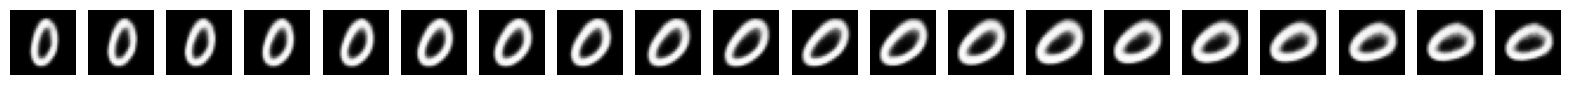

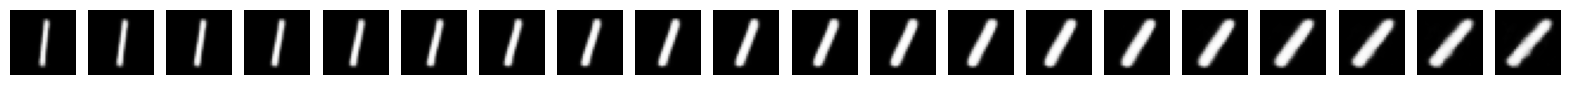

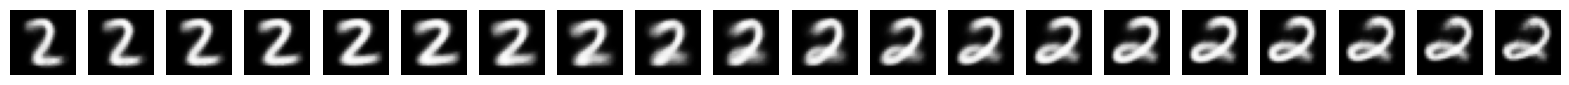

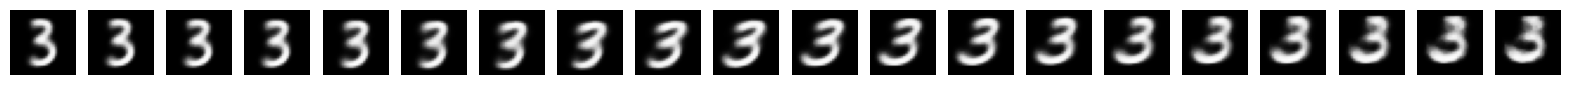

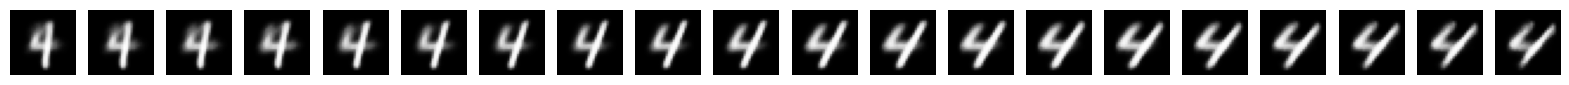

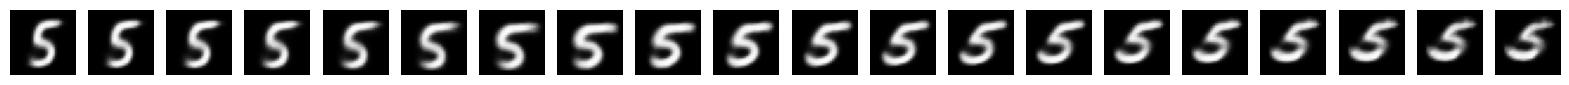

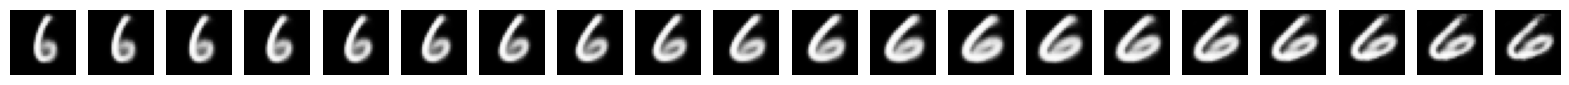

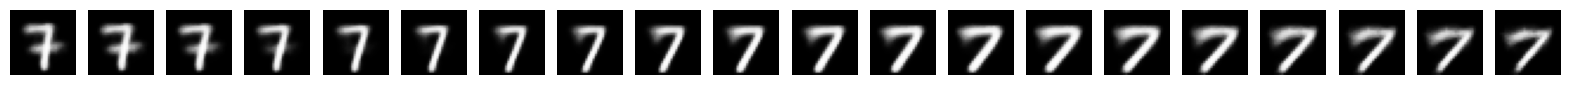

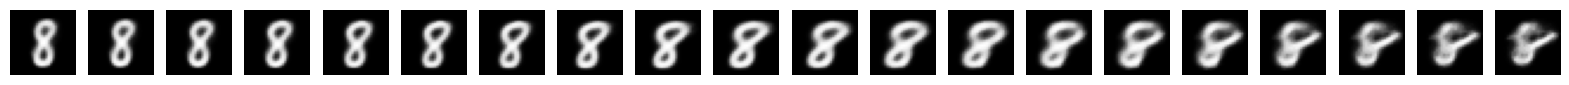

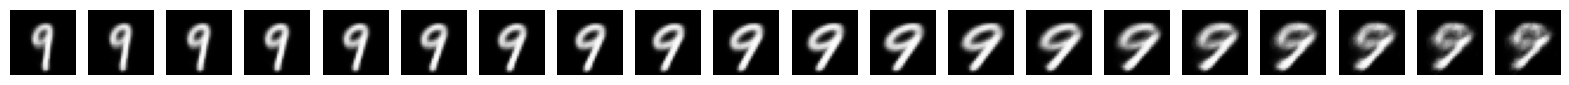

In [28]:
# exploring the latent space: change z sample on the x&y-axis
digit_size = 28
for cond_num in range(10):
    condition_num = to_categorical(cond_num, 10).reshape(1, -1)
    plt.figure(figsize=(20, 2))
    x_range_start = -1.6
    y_range_start = -0.4

    for i in range(20):
        z_sample = np.array([[x_range_start, y_range_start]])
        x_decoded = generator.predict(np.column_stack([z_sample, condition_num]))
        digit = x_decoded[0].reshape(digit_size, digit_size)

        plt.subplot(1, 20, i + 1)
        plt.axis("off")
        plt.imshow(
            digit,
            cmap="Greys_r",
        )
        x_range_start += 0.2 #x-axis will range from -2 to 2 in 20 iteration
        y_range_start += 0.1 #y-axis will range from -1 to 1 in 20 iteration

plt.show()

- Here we can see the generated images of 0 to 9 digits from the latent space where x-range starts from -1.6 and y-range starts from -0.4 and increases 0.2 and 0.1 respectively. We can see how different generation shows different stroke style and sharpness of the digits.

### Conditional generation

Now, we will generate the digit 7 and try to understand by comparing with the directly printed digit 7 from the MNIST dataset.


1/1 [==============================] - 0s 64ms/step


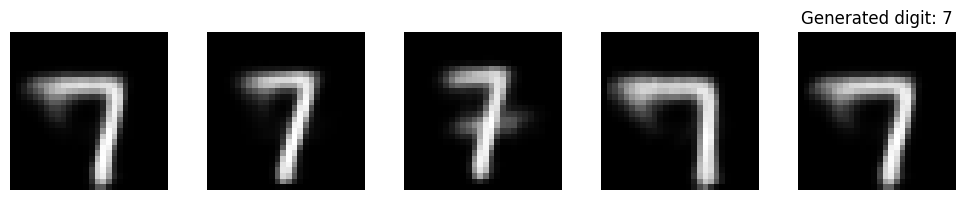

In [29]:
def generate_digits(model, digit, latent_dim, num_images):
    # Create one-hot encoded vector for the desired digit, repeated for num_images
    condition_vectors = np.zeros((num_images, 10))  # Assuming 10 classes for digits 0-9
    condition_vectors[:, digit] = 1

    # Sample from the latent space, generating num_images samples
    z_samples = np.random.normal(size=(num_images, latent_dim))

    # Concatenate the latent vectors and condition vectors
    z_conds = np.concatenate([z_samples, condition_vectors], axis=1)

    # Generate images from the decoder
    generated_images = model.predict(z_conds)

    return generated_images


# Generate 5 images of given digits 
digit_to_generate = 7
num_images = 5
generated_images = generate_digits(generator, digit_to_generate, z_dim, num_images)


fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
for i, img in enumerate(generated_images):
    axes[i].imshow(img.reshape(28, 28), cmap="gray")
    axes[i].axis("off")
plt.title(f"Generated digit: {digit_to_generate}")
plt.tight_layout()
plt.show()

- The pictures are more blurry than the real dataset but we can clearly undertand the digit and its different strokes.

### Dimensionality reduction and Visualization

Now we will visualize the encoded latent space using t-SNE, a popular technique for dimensionality reduction and visualization.

In [30]:
mu = encoder.predict([x_test, y_test], batch_size=batch_size)

# Configure t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(mu)

500/500 [==============================] - 2s 4ms/step
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.043s...
[t-SNE] Computed neighbors for 10000 samples in 0.475s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.076483
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.620102
[t-SNE] KL divergence a

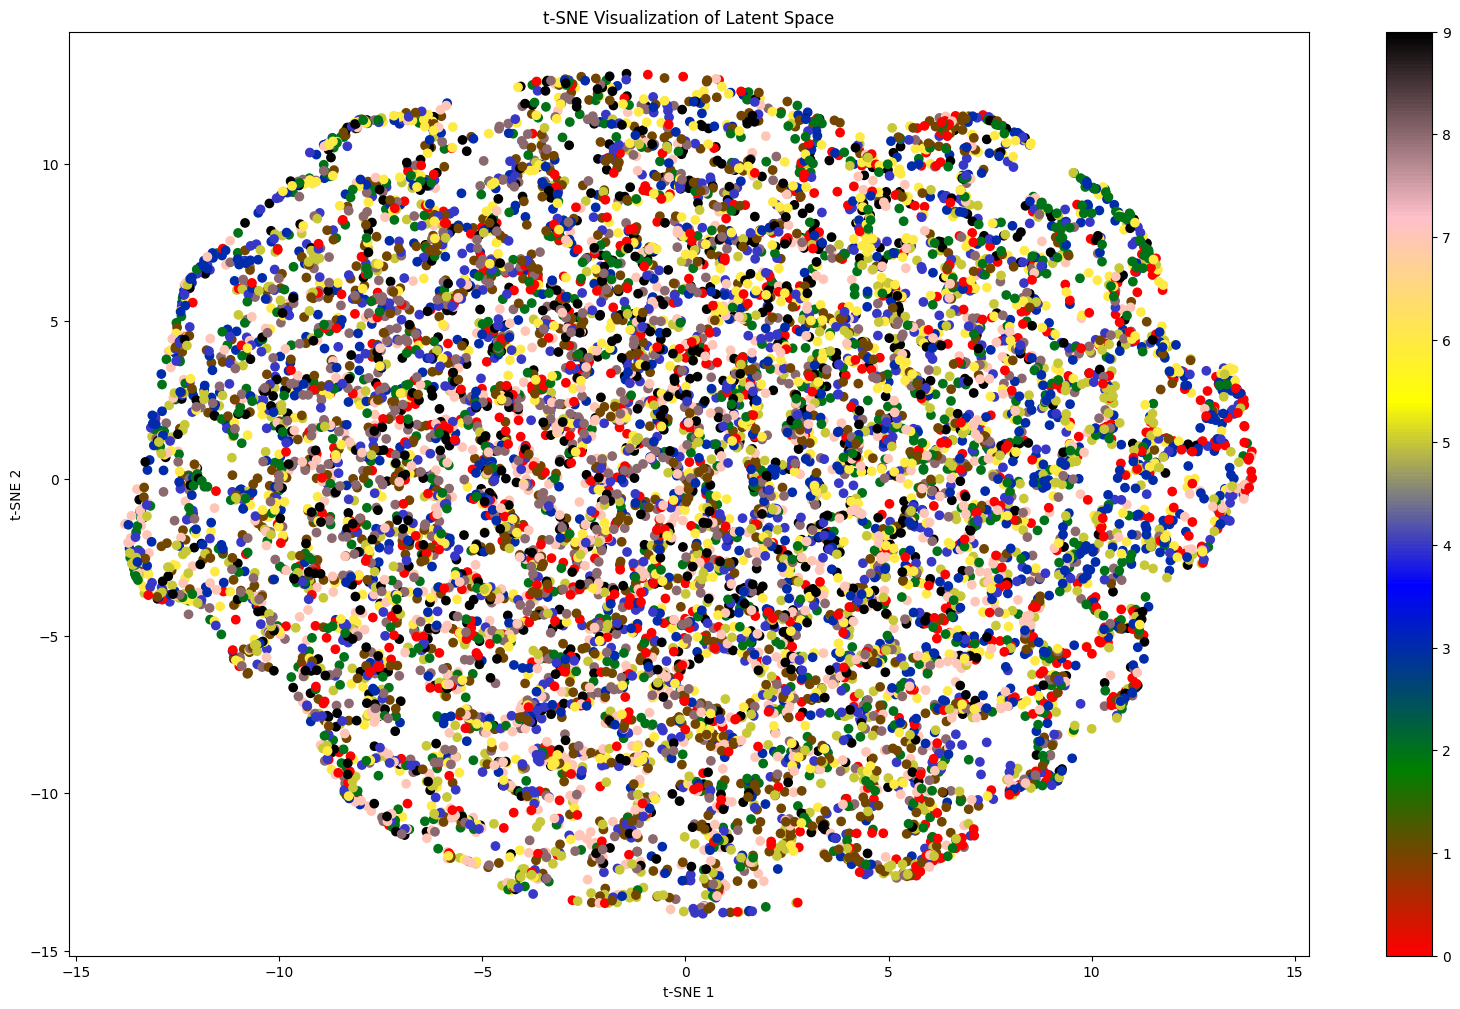

In [31]:
plt.figure(figsize=(20, 12))
scatter = plt.scatter(
    tsne_results[:, 0], tsne_results[:, 1], c=np.argmax(y_test, axis=1), cmap=custom_cmap
)
plt.colorbar(scatter)
plt.title("t-SNE Visualization of Latent Space")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

- The figure shows the points are not tightly clustered into clear groups. Instead, they are spread across the 2D space with noticeable overlaps. This pattern suggests that while the latent space representation contains some meaningful structure for distinguishing digits, the separation between classes isn't very strong. The overlap between classes may occur due to similar characteristics in the digits. For example 3, 8 or 8, 9 or 5, 6 has similar features that are difficult to seperate. Improving the model architecture or fine-tuning the hyperparameters could potentially yield more distinct clusters.

#### References:
https://papers.nips.cc/paper/5775-learning-structured-output-representation-using-deep-conditional-generative-models